In [29]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MacroDataAnalysis").getOrCreate()
df_spark = spark.read.csv("/Users/malharpatil/Downloads/macro_data_25yrs.csv", header=True)
numeric_cols = ['M2_Money_Supply', '10Y Treasury Yield', 'Fed Funds Rate', 'CPI', 'Inflation_Rate_%', 'SOFR']
df_clean = df_spark.na.drop(subset=numeric_cols)
df_clean.show(5)

+----------+---------------+------------------+--------------+-------+------------------+----+
|      Date|M2_Money_Supply|10Y Treasury Yield|Fed Funds Rate|    CPI|  Inflation_Rate_%|SOFR|
+----------+---------------+------------------+--------------+-------+------------------+----+
|2018-04-03|        13993.9|              2.87|          1.69|250.227|2.4709963021052994|1.83|
|2018-04-04|        13993.9|              2.87|          1.69|250.227|2.4709963021052994|1.74|
|2018-04-05|        13993.9|              2.87|          1.69|250.227|2.4709963021052994|1.75|
|2018-04-06|        13993.9|              2.87|          1.69|250.227|2.4709963021052994|1.75|
|2018-04-09|        13993.9|              2.87|          1.69|250.227|2.4709963021052994|1.75|
+----------+---------------+------------------+--------------+-------+------------------+----+
only showing top 5 rows


In [30]:
df_clean.select(numeric_cols).describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|   M2_Money_Supply|10Y Treasury Yield|   Fed Funds Rate|               CPI|  Inflation_Rate_%|              SOFR|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|              1809|              1809|             1809|              1809|              1809|              1809|
|   mean|19037.177059148667|2.7582863460475453|2.493007186290749|282.05862797125496|3.5868531528901015|2.4845881702598094|
| stddev| 2860.972559958819|1.2657783571291306|2.002738562141608|24.835317971619578| 2.259494332246502| 2.012879123607224|
|    min|           13993.9|              0.62|             0.05|           250.227|0.1982013035848551|              0.01|
|    max|           21942.0|               4.8|             5.33|            320.58| 8.999298141923106|               5.4|
+-------+-------

In [40]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
import numpy as np

# Cast each numeric column as Double
for col_name in numeric_cols:
    df_clean = df_clean.withColumn(col_name, col(col_name).cast("double"))

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_clean).select("features")

correlation_matrix = Correlation.corr(df_vector, "features", "pearson").head()[0]

corr_array = correlation_matrix.toArray()

inflation_index = numeric_cols.index('Inflation_Rate_%')

inflation_correlations = corr_array[inflation_index]

for i, col_name in enumerate(numeric_cols):
    print(f"{col_name}: {inflation_correlations[i]}")

M2_Money_Supply: 0.5666457048246515
10Y Treasury Yield: 0.16981305132625854
Fed Funds Rate: -0.06505562304783251
CPI: 0.3436691309252041
Inflation_Rate_%: 1.0
SOFR: -0.07622535250038147


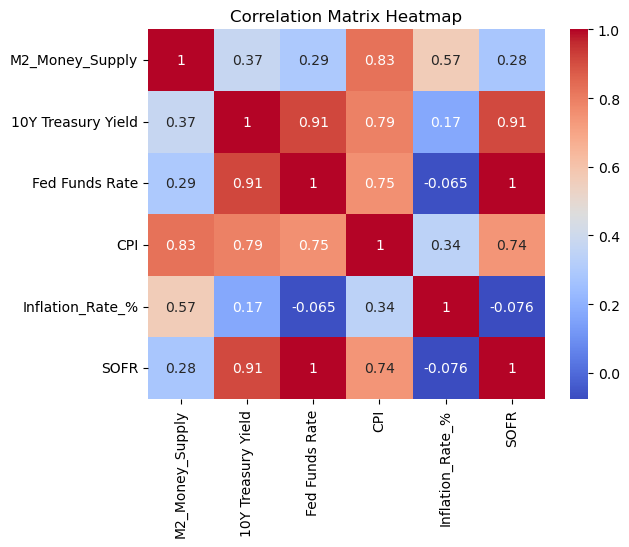

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for better visualization
corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

# Plot the heatmap
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [71]:
from pyspark.ml.regression import LinearRegression

assembler_reg = VectorAssembler(inputCols=["M2_Money_Supply", "10Y Treasury Yield"], outputCol="features")
final_df = assembler_reg.transform(df_clean).select("features", "Inflation_Rate_%")

lr = LinearRegression(featuresCol='features', labelCol='Inflation_Rate_%')
lr_model = lr.fit(final_df)

summary = lr_model.summary
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
print("R2:", summary.r2)
print("P-values:", summary.pValues)

Coefficients: [0.000461999424399604,-0.08750591532026762]
Intercept: -4.96694531920364
R2: 0.32315414426876665
P-values: [0.0, 0.01896431702249135, 0.0]


25/07/29 16:18:36 WARN Instrumentation: [f5dba9e6] regParam is zero, which might cause numerical instability and overfitting.
